# Exploring 3D ROCurves

Traditionally ROC curves are 2D - signal and background. But our MVA currently has three variables. What can we do in order to understand the ROC curves for that sort of a situation?

## Initalization

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14) # Font size for titles and axes, default is 10
from mpl_toolkits.mplot3d import Axes3D # if this isn't done then the 3d projection isn't known. Aweful UI!
from sklearn.metrics import roc_curve, auc

## Loading Data

Data is stored in a directory somewhere on the server machine. So this is not likely to be portable.
The job number is also kept seperate to make it easy to update everything.

In [2]:
data_location = "..\\..\\MCAResultsData"
jenkins_build = 165

In [3]:
signal_sample_names=["125pi25lt5m", "200pi25lt5m", "400pi50lt5m", "600pi150lt5m", "1000pi400lt5m"]
bib_sample_names=["data15", "data16"]
mj_sample_names=["jz"]

Next, actual loading of the data. If a file isn't there, we don't really care.

In [4]:
def load_mva_data(sample_name):
    """Load the data written out by a MVA training job into an np array.
    Returns null if the csv file can't be found.
    
    Args:
      sample_name: The name of the sample, e.g. data15
    """
    p = "{0}\\{1}\\all-{2}.csv".format(data_location, jenkins_build, sample_name)
    if not os.path.exists(p):
        return None
    return pd.read_csv(p)

def load_mva_data_from_list(lst):
    """Load data for a series of samples. Silently ignore those we can't find
    
    Args:
        lst: List of samples to load
    """
    return {s[0] : s[1] for s in [(sname, load_mva_data(sname)) for sname in lst] if not(s[1] is None)}

In [5]:
signal_samples = load_mva_data_from_list(signal_sample_names)
bib_samples = load_mva_data_from_list(bib_sample_names)
mj_samples = load_mva_data_from_list(mj_sample_names)

## Basic Plots

Make some basic plots of the weights for each simple individually.

In [8]:
def plot_mva_sample(sample_name, sample_data):
    """Plot the HSS, BIB, and MJ all on one plot as a histogram
    
    Args:
      sample_data: The DataFrame that contains the data for this sample
    """
    nbins = 100
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    plt.hist([sample_data['HSSWeight'], sample_data["MultijetWeight"], sample_data["BIBWeight"]],
             weights=[sample_data.Weight, sample_data.Weight, sample_data.Weight],
             bins=nbins,
             histtype = 'step', normed=True,
             color=['red', 'blue', 'green'],
             label=['HSS Weight', 'Multijet Weight', 'BIB Weight'])
    plt.title("BDT Weights for Sample {0}".format(sample_name))
    plt.xlabel('MVA Weight')
    plt.legend()
    ax.set_yscale('log')
    
def plot_mva_samples(dict_of_samples):
    for k in dict_of_samples.keys():
        plot_mva_sample(k, dict_of_samples[k])
        plt.show()

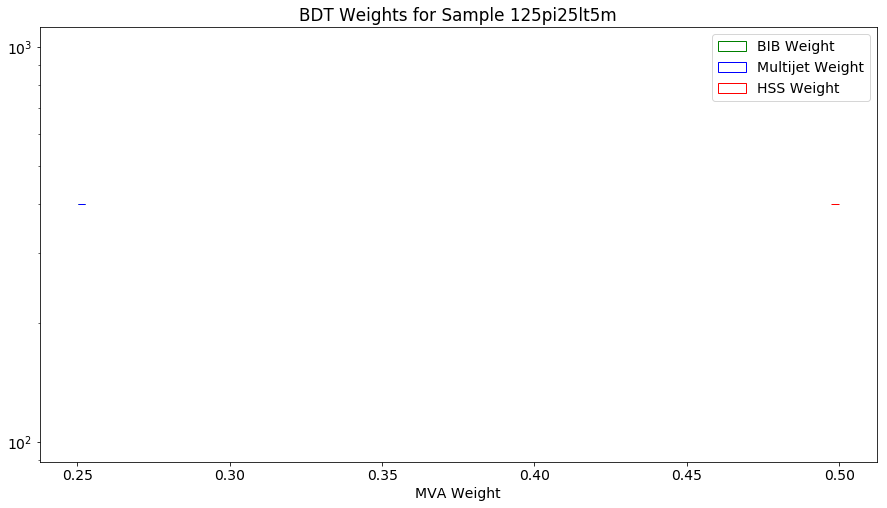

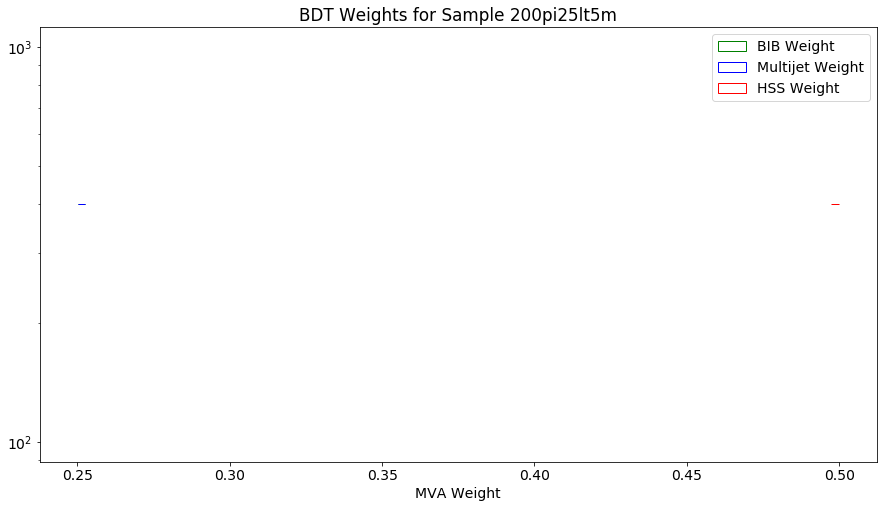

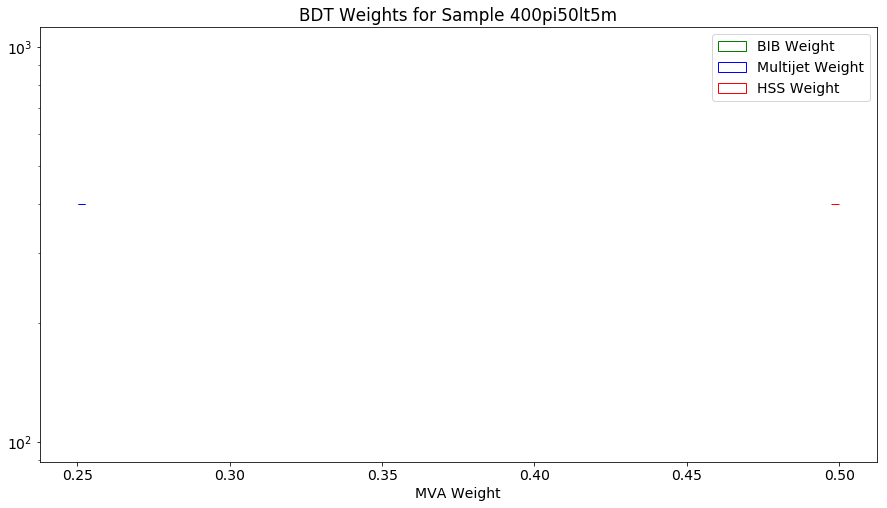

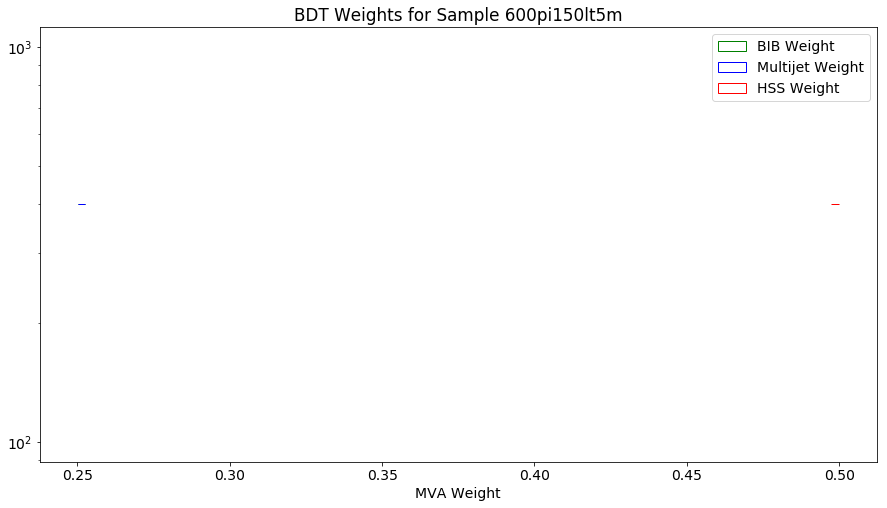

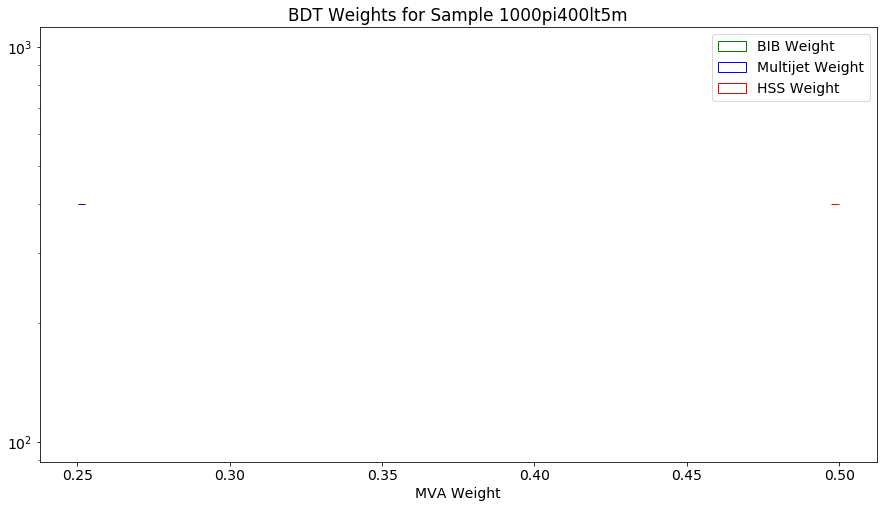

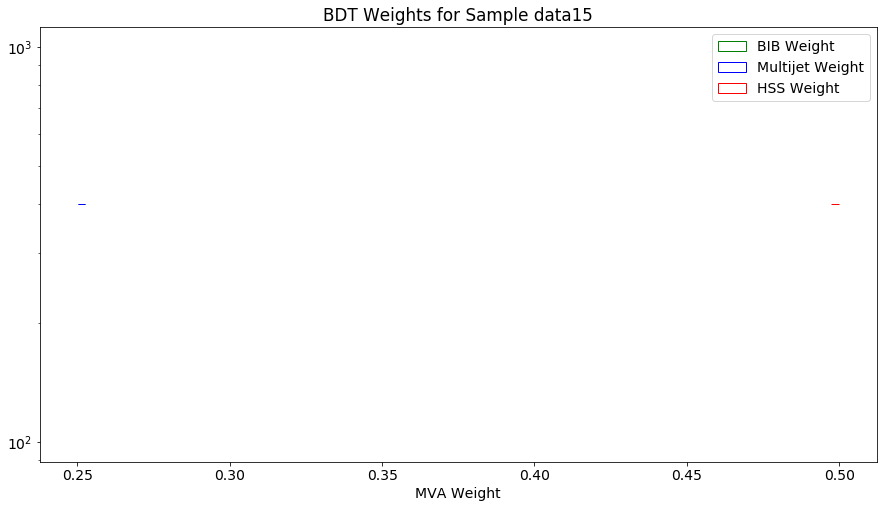

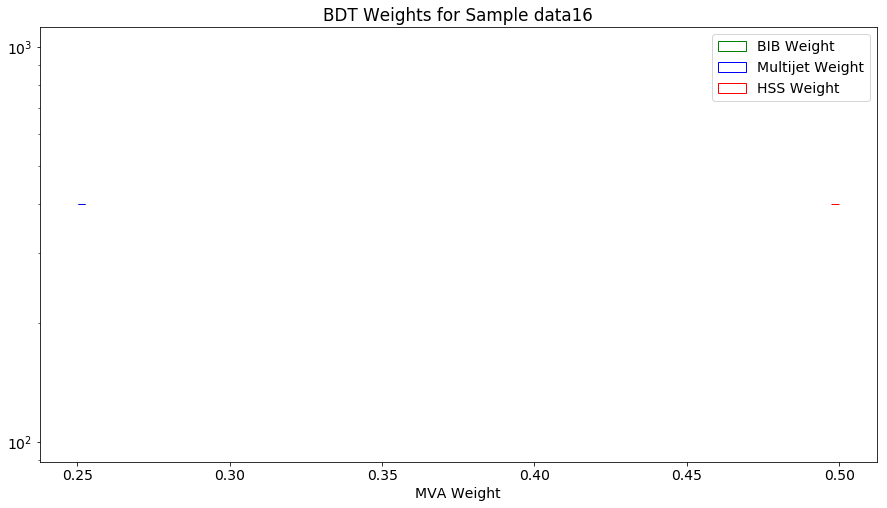

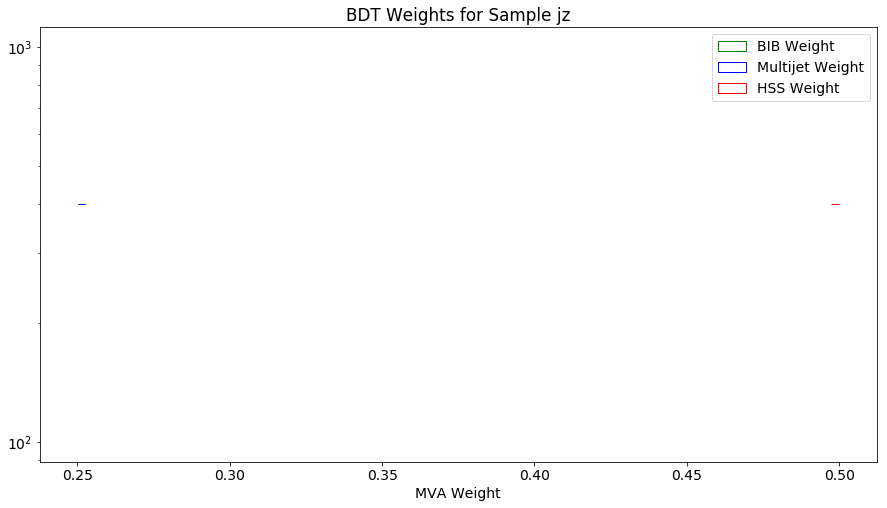

In [10]:
plot_mva_samples({**signal_samples, **bib_samples, **mj_samples})

A plot of MVA values where we take advantage of the fact that they all add up to 1.

In [8]:
def split_data_in_slices (sample, weight, divisions = 20):
    '''Split a sample up along a given axis. In each bin calculate the average
    
    Args:
        sample  -  The sample DataFrame we are going to split
        weight - Name of weight axis to split by
        divisions - How many equal sized bins to split this into
    
    Returns:
        DataFrame with rows labeled by the lower edge of the sliced bin, and average
        weight for HSS, MultiJet, and BIB, and a column with the # of events in each bin.
    '''
    s = sample.drop('Weight', axis=1)
    pdiv = 1.0/divisions
    slice_edges = [(b*pdiv, pdiv*(b+1)) for b in range(divisions)]

    mean_evolution = {se[0]:s[(s[weight] >= se[0]) & (s[weight] < se[1])].mean() for se in slice_edges}
    count = {se[0]:len(s[(s[weight] >= se[0]) & (s[weight] < se[1])].index) for se in slice_edges}

    me = pd.DataFrame(mean_evolution).T
    me['SliceCount']=pd.Series(list(count.values()), index=me.index)
    return me

def split_data_in_slices_for_all (samples, weight, divisions = 20):
    '''Split all the samples in the dict samples
    
    Args
        samples - dict of all samples
        weight - Name of weight axis to split along
        divisions - how many equal bins to split things into
        
    Return
        Dict of results
    '''
    return {name:split_data_in_slices(samples[name],weight,divisions) for name in samples}

In [10]:
slc = split_data_in_slices(mj_samples["jz"], ' MultijetWeight')
slc

,HSSWeight,MultijetWeight,BIBWeight,SliceCount
0.00,0.927814,0.020984,0.051202,17194
0.05,0.701762,0.072752,0.225486,13507
0.10,0.549762,0.119639,0.330600,12403
0.15,0.575516,0.176023,0.248461,6746
0.20,0.443867,0.225545,0.330588,7182
0.25,0.375721,0.274525,0.349753,7654
0.30,0.276609,0.326760,0.396631,10924
0.35,0.235579,0.377784,0.386638,15828
0.40,0.211616,0.430961,0.357423,27794
0.45,0.165853,0.474576,0.359571,36955


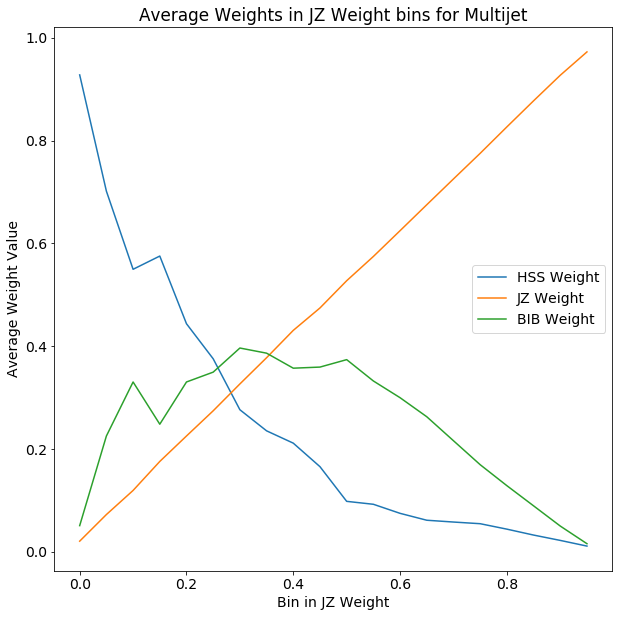

In [15]:
def plot_average_weights (sample, sample_name, slice_weight_name):
    '''Plot the slice data for a particular sample
    
    Args
        sample - slice data for the sample
        sample_name - the name of the sample we will put on plot
        weight_name - the weight name that was used to slice everything
        
    Returns
        Plot drawn on the current figure.
    '''
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(sample.index, sample[' HSSWeight'], label='HSS Weight')
    ax.plot(sample.index, sample[' MultijetWeight'], label='JZ Weight')
    ax.plot(sample.index, sample[' BIBWeight'], label="BIB Weight")
    ax.set_xlabel('Bin in {0}'.format(slice_weight_name))
    ax.set_ylabel('Average Weight Value')
    ax.set_title('Average Weights in {0} bins for {1}'.format(slice_weight_name, sample_name))
    plt.legend()

plot_average_weights(slc, "Multijet", "JZ Weight")
plt.show()

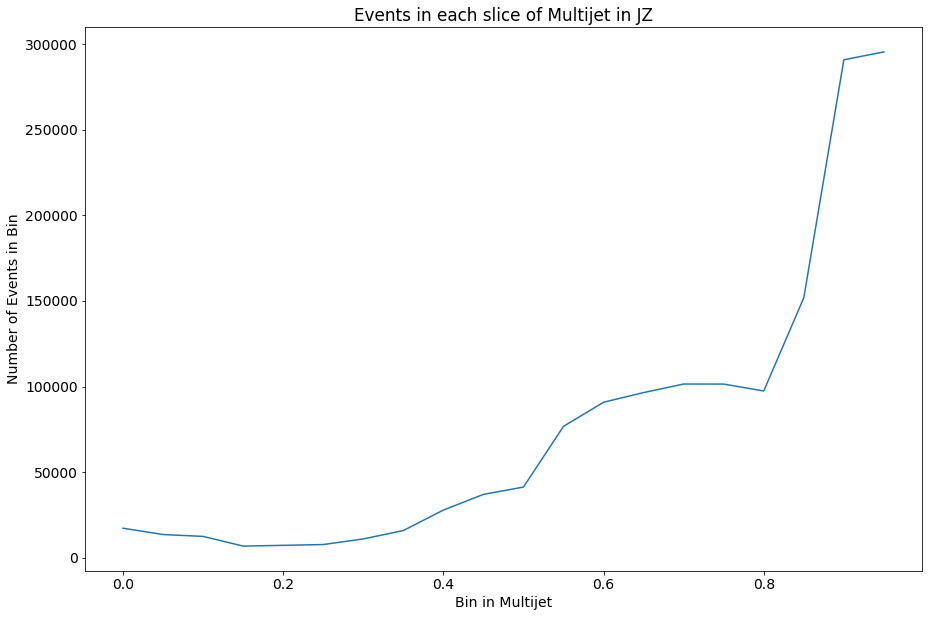

In [18]:
def plot_slice_sizes (sample, sample_name, slice_weight_name):
    '''Plot the number of events in each slice
    
    Args
        sample - Slice data for a sample
        sample_name - name of the sample for plot title
        slice_weight_name - name of weight that that is used to slice
        
    Returns
        Default plot of the number of events
    '''
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.plot(sample.index, sample.SliceCount)
    ax.set_xlabel('Bin in {0}'.format(slice_weight_name))
    ax.set_ylabel('Number of Events in Bin')
    ax.set_title('Events in each slice of {0} in {1}'.format(slice_weight_name, sample_name))

plot_slice_sizes(slc, 'JZ', 'Multijet')
plt.show()

## 3D Scatter Plots

Plotting a full 3D scatter plot is very time consuming! It takes more than 5 minutes on my computer. So becareful executing through this guy.

In [8]:
def plot_mva_scatter_plot (sample_name, signal_data, bib_data, background_data):
    """Plot the results as a scatter plot for """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    args = {'marker': '.'}
    
    ax.scatter(signal_data[" HSSWeight"], signal_data[" MultijetWeight"], signal_data[" BIBWeight"], color='b', **args)
    ax.scatter(bib_data[" HSSWeight"], bib_data[" MultijetWeight"], bib_data[" BIBWeight"], color='g', **args)
    ax.scatter(background_data[" HSSWeight"], background_data[" MultijetWeight"], background_data[" BIBWeight"], color='r', **args)
    ax.set_xlabel('HSS')
    ax.set_ylabel('Multijet')
    ax.set_zlabel('BIB')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_zlim([0.0, 1.0])
    plt.show()

In [9]:
#plot_mva_scatter_plot("dude", signal_samples["125pi25lt5m"], bib_samples["data15"], mj_samples["jz"])

## ROC Curves

Look at ROC curves as a function of BIB cut.

These are mutli-class results - so w_hss + w_mj + w_bib = 1.0. Yet for the ROC curve we have to look at a single weight.

In [10]:
def roc_curve_calc(signal, background, weight=' HSSWeight'):
    '''Calculate a ROC curve
    
    Args:
        signal - data frame that contains the signal
        background - data frame that contains teh background
        weight - the column in the DataFrame that we pull the weights from
        
    Returns
        tpr - true positive rate
        fpr - false postive rate
        auc - Area under the curve for the tpr/fpr curve - bigger is better!
    '''
    # build a single array marking one as signal and the other as background
    truth = np.concatenate((np.ones(len(signal.index)), np.zeros(len(background.index))))
    score = np.concatenate((signal[weight], background[weight]))
    (fpr, tpr, thresholds) = roc_curve(truth,score)
    
    a = auc(fpr, tpr)
    
    return (tpr, fpr, a)

def plot_roc_curve (tpr, fpr, aroc, signal_name = 'Signal', background_name = 'JZ'):
    '''Plot a ROC curve
    
    Args:
        tpr - True positive rate
        fpr = False postiive rate
        aroc - the area under the curve (in the legend)
        signal_name - for the signal axis label
        background_name - for the background axis name
    '''
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange', label='ROC Curve area {0:0.2f}'.format(aroc))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('{0} Positive Rate'.format(signal_name))
    plt.xlabel('{0} Postiive Rate'.format(background_name))
    plt.legend()

In [11]:
tpr, fpr, aroc = roc_curve_calc(signal_samples["125pi25lt5m"], mj_samples["jz"])

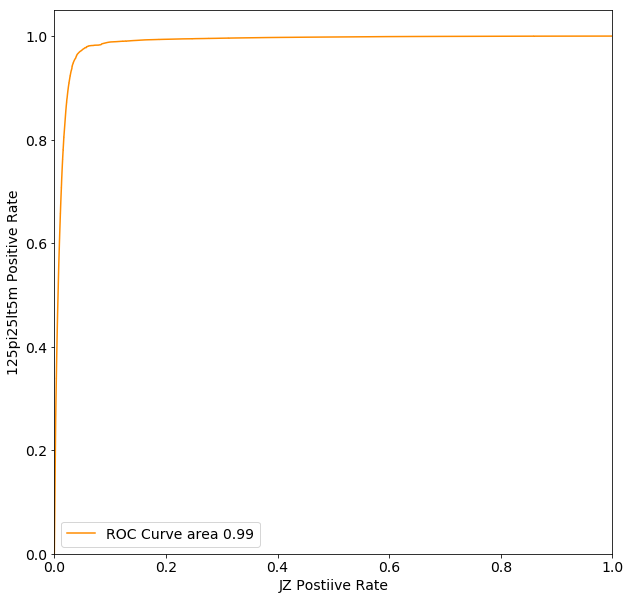

In [12]:
plot_roc_curve(tpr, fpr, aroc, signal_name = "125pi25lt5m")
plt.show()

In [73]:
def calc_roc_with_bib_cut (sig, back, bib, bib_cut = 0.5):
    '''Calc ROC curve basics after limiting the data sample for a particular bib cut
    
    Args:
        sig - signal DataFrame
        back - background DataFrame
        bib - the bib sample
        bib_cut - only events with a bib value less than this number will be included
        
    Returns:
        tpr - true positive rate
        fpr - false positive rate
        aroc - area under the ROC curve
        sig_eff - How much signal this bib cut removed
        back_eff - how much background this bib cut removed
        bib_eff
    '''
    gsig = sig[sig[' BIBWeight']<bib_cut]
    sig_eff = len(gsig.index)/len(sig.index)
    gback = back[back[' BIBWeight']<bib_cut]
    back_eff = len(gback.index)/len(back.index)
    gbib = bib[bib[' BIBWeight']<bib_cut]
    bib_eff = len(gbib.index)/len(bib.index)
    
    tpr, fpr, aroc = roc_curve_calc(gsig, gback)
    
    return (tpr, fpr, aroc, sig_eff, back_eff, bib_eff)

def calc_roc_family (sig, back, bib, bib_cut_range = np.logspace(-3,0,30)):
    '''Calc ROC Curve for a family of bib cuts
    
    Args:
        sig - signal DataFrame
        back - background (jz) DataFrame
        bib - bib DataFrame
        bib_cut_range - Value of bib efficiencies to look at. Actual cuts are determined from this

    Returns:
        all - DataFrame of truth and false postive rate, area under curve, sig, back, and bib eff, and the bib cut
    '''
    sorted_bib_values = bib[' BIBWeight'].sort_values()
    lst_len = len(sorted_bib_values.index)-1
    bib_cut_values = [sorted_bib_values.values[index] for index in [int(lst_len*cut_fraction) for cut_fraction in bib_cut_range]]
    all = [calc_roc_with_bib_cut (sig, back, bib, bib_cut = bc)+(bc,) for bc in bib_cut_values]
    return pd.DataFrame(all, columns=['tpr', 'fpr', 'aroc', 'sig_eff', 'back_eff', 'bib_eff', 'bib_cut'])

In [74]:
p125 = calc_roc_family(signal_samples["125pi25lt5m"], mj_samples["jz"], bib_samples['data15'])

In [75]:
p125

,tpr,fpr,aroc,sig_eff,back_eff,bib_eff,bib_cut
0,"[0.0, 0.049575703439, 0.0667193458618, 0.07623...","[0.0, 0.00256715127277, 0.00353996649192, 0.00...",0.964623,0.149427,0.024671,0.000990,0.000731
1,"[0.0, 0.0395320804339, 0.0532025642431, 0.0607...","[0.0, 0.00200493848005, 0.0027647046409, 0.003...",0.968089,0.187391,0.031589,0.001258,0.001516
2,"[0.0, 0.0318958466877, 0.0429256647731, 0.0490...","[0.0, 0.00157710377343, 0.0021747430981, 0.002...",0.970401,0.232254,0.040158,0.001605,0.002814
3,"[0.0, 0.0280515542077, 0.0377519877141, 0.0431...","[0.0, 0.00130532159002, 0.0017999697715, 0.002...",0.972399,0.264083,0.048519,0.002033,0.004018
4,"[0.0, 0.0250795140518, 0.0337521942402, 0.0385...","[0.0, 0.00105864916367, 0.00145982147832, 0.00...",0.974982,0.295378,0.059825,0.002569,0.005460
5,"[0.0, 0.0224068322981, 0.0301552795031, 0.0344...","[0.0, 0.000831291564578, 0.00114630731537, 0.0...",0.977696,0.330611,0.076187,0.003264,0.007420
6,"[0.0, 0.0208888245512, 0.0281123335263, 0.0321...","[0.0, 0.000706093962525, 0.000973666411482, 0....",0.979423,0.354637,0.089696,0.004174,0.009010
7,"[0.0, 0.0192811330839, 0.0259486905398, 0.0296...","[0.0, 0.000587318858499, 0.000809881794352, 0....",0.981104,0.384207,0.107835,0.005298,0.011174
8,"[0.0, 0.0181593949385, 0.0244390471037, 0.0279...","[0.0, 0.000497671421612, 0.00068626269717, 0.0...",0.982714,0.407940,0.127260,0.006716,0.013196
9,"[0.0, 0.0170018733873, 0.0228812460971, 0.0261...","[0.0, 0.000418001337604, 0.000576401844486, 0....",0.984155,0.435713,0.151515,0.008508,0.015809


In [76]:
p_samples = {sname:calc_roc_family(signal_samples[sname], mj_samples["jz"], bib_samples['data15']) for sname in signal_samples.keys()}

Lets look at the eff plot for all samples as a function of the bib cut

In [126]:
def plot_eff_for_bib(ps, sample_name):
    '''Plot the Efficiency plots for a single sample
    
    Args:
        ps - DataFrame of the sample we will look at
        sample_name - Name of sample
    '''
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.plot(ps.bib_eff,ps.sig_eff, label='Sample {0}'.format(sample_name))
    plt.plot(ps.bib_eff,ps.back_eff, label='Sample JZ')
    plt.plot(ps.bib_eff,ps.bib_eff, label='Sample BIB')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.001, 1.0])
    plt.xlabel('BIB Fraction')
    plt.ylabel('Fraction of Events')
    ax.set_xscale('log')
    plt.grid(alpha=0.5, which='both')
    plt.title('{0}, JZ, and BIB Efficiencies as a function of BIB Fraction'.format(sample_name))
    plt.legend()

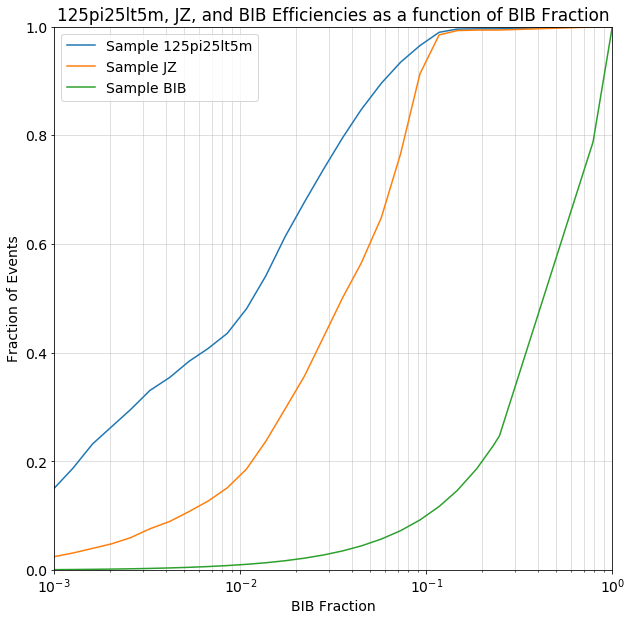

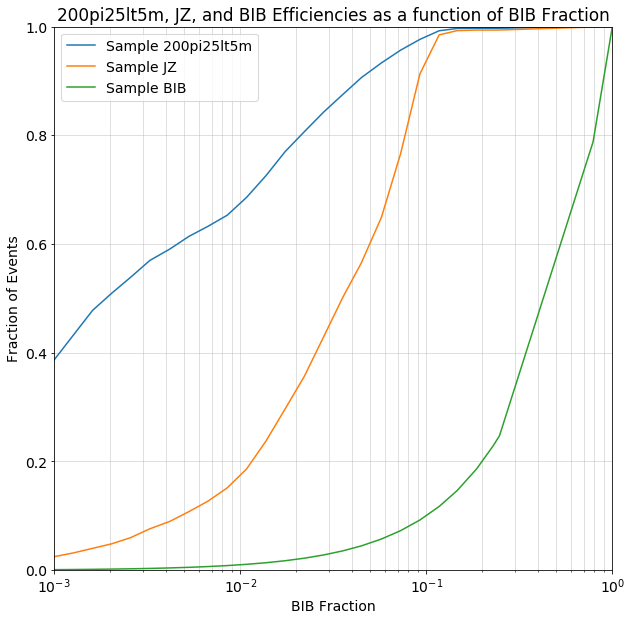

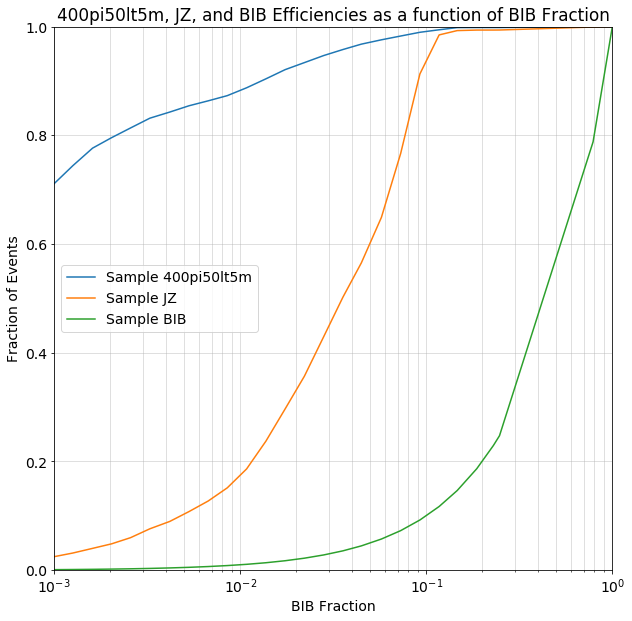

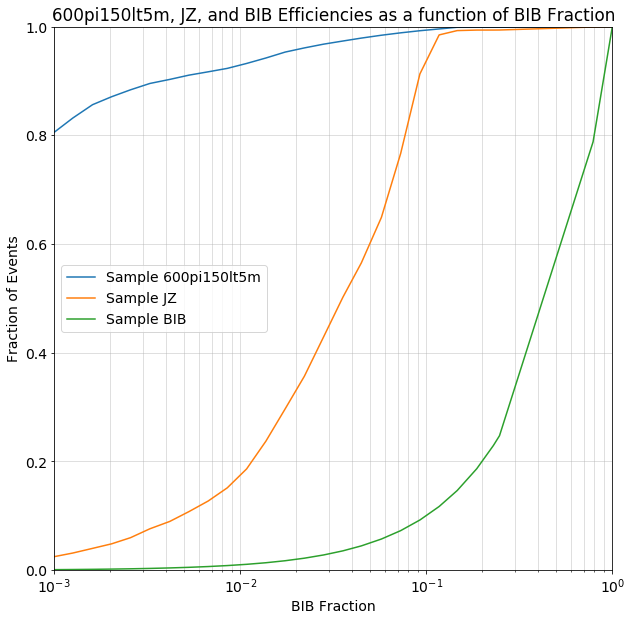

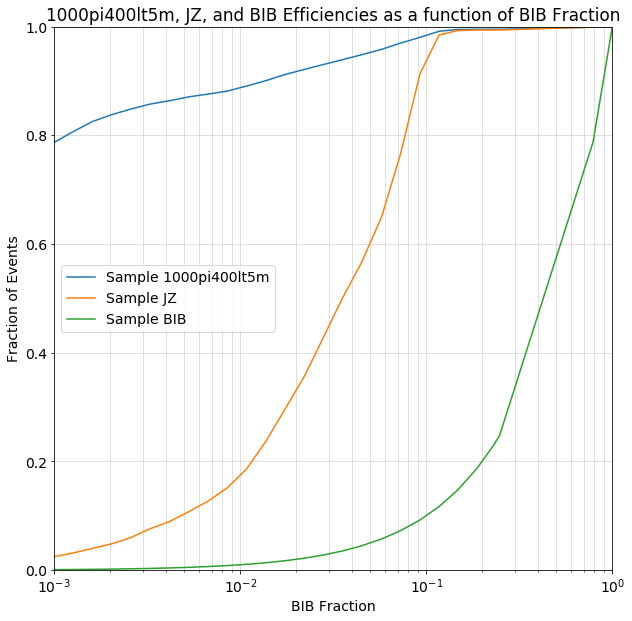

In [127]:
for sname in p_samples.keys():
    plot_eff_for_bib(p_samples[sname], sname)
    plt.show()

Try plotting the family of signal efficencies on the same plot

In [124]:
def plot_all_eff_for_bib(samples):
    '''Plot the efficiency plots for all samples and JZ and BIB
    
    Args
        samples - The df containing all singal samples ROC calculations with eff loaded
    '''
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    # Do the eff samples
    for s in samples:
        plt.plot(samples[s].bib_eff,samples[s].sig_eff, label='Sample {0}'.format(s))
    # Do the background
    abck=samples[list(samples.keys())[0]]
    plt.plot(abck.bib_eff,abck.back_eff, label='Sample JZ')
    plt.plot(abck.bib_eff,abck.bib_eff, label='Sample BIB')
    # Get the plot in shape
    plt.ylim([0.0, 1.0])
    plt.xlim([0.001, 1.0])
    plt.xlabel('BIB Fraction')
    plt.ylabel('Fraction of Events')
    plt.title('Signal, JZ, and BIB Efficiencies as a function of BIB Fraction')
    ax.set_xscale('log')
    plt.legend()

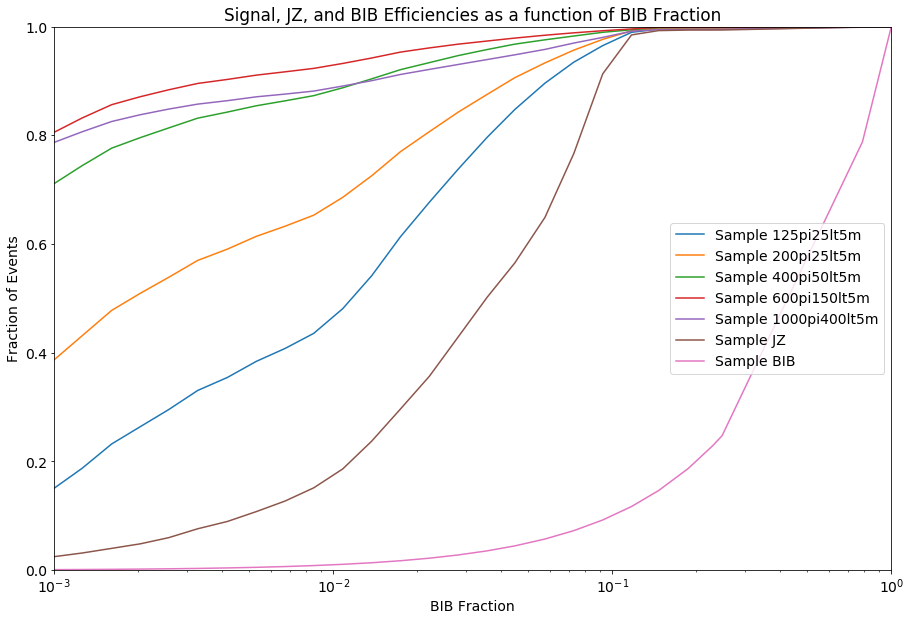

In [125]:
plot_all_eff_for_bib(p_samples)
plt.show()

Look at a faimly of ROC plots now, for each BIB cut

In [123]:
def plot_roc_family_sample(sample_info_bib, sample_name, background_name = 'JZ', nsamples=10):
    '''Plot a family of scaled ROC curves
    
    Args:
        sample_info_bib - Each row has a DF containing info on each bib cut point
        sample_name - Name of the sample (for plot title)
        background_name - Name of the background samples (JZ usually)
        nsamples - sample the list of bib cuts (if there are too many)
        
    Returns
        None
        But matplotlib will be sitting at a plot
    '''
    resample = 1
    if nsamples <= len(sample_info_bib.index):
        resample = int(len(sample_info_bib.index)/nsamples)
    f = plt.figure(figsize=(15,10))
    ax = f.add_subplot(111)
    for index,r in sample_info_bib.iloc[::-resample].iterrows():
        sig_scale = r.sig_eff
        back_scale = r.back_eff
        ax.plot(r.fpr*back_scale, r.tpr*sig_scale, label='BIB Cut {0:0.4f} eff={1:0.3f} (AROC={2:0.3f})'.format(r.bib_cut, r.bib_eff, r.aroc))
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('{0} Positive Rate'.format(sample_name))
    plt.xlabel('{0} Postiive Rate'.format(background_name))
    plt.title('ROC curves for {0} as a function of BIB cut'.format(sample_name))
    plt.legend()

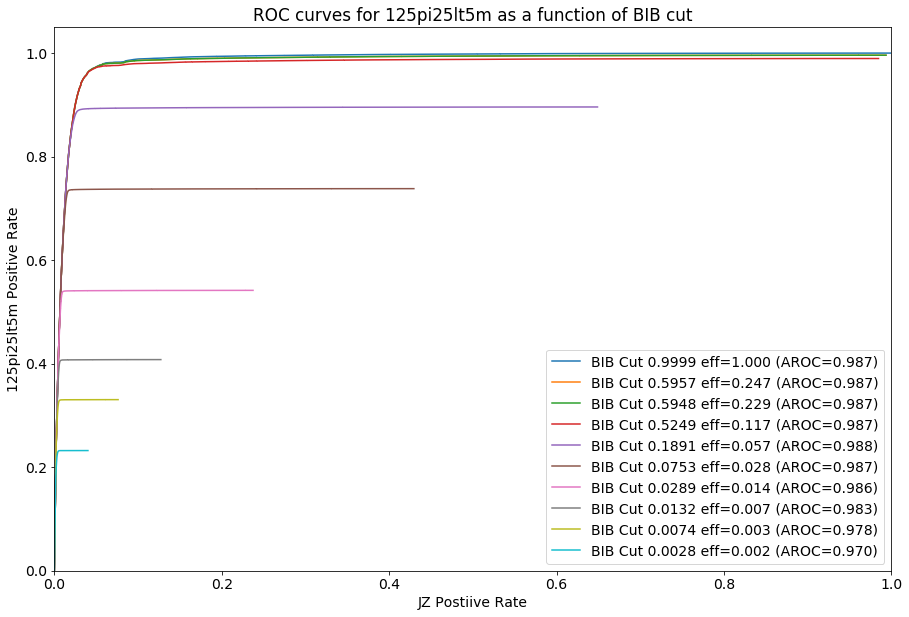

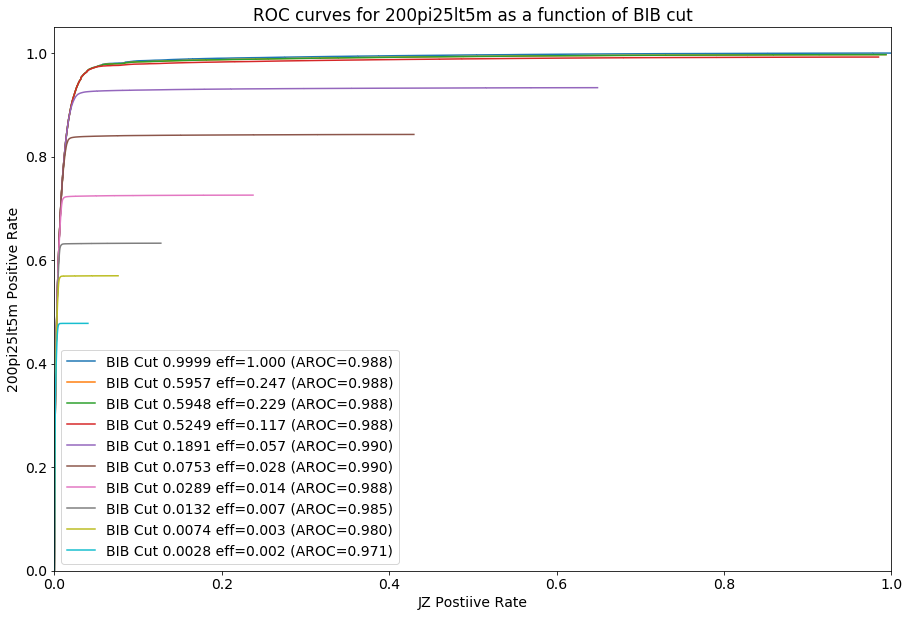

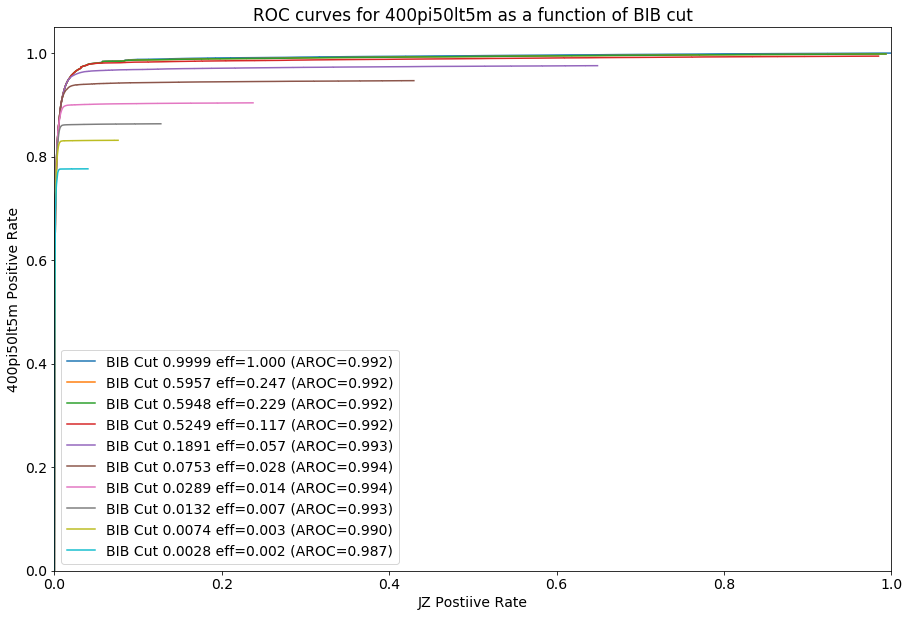

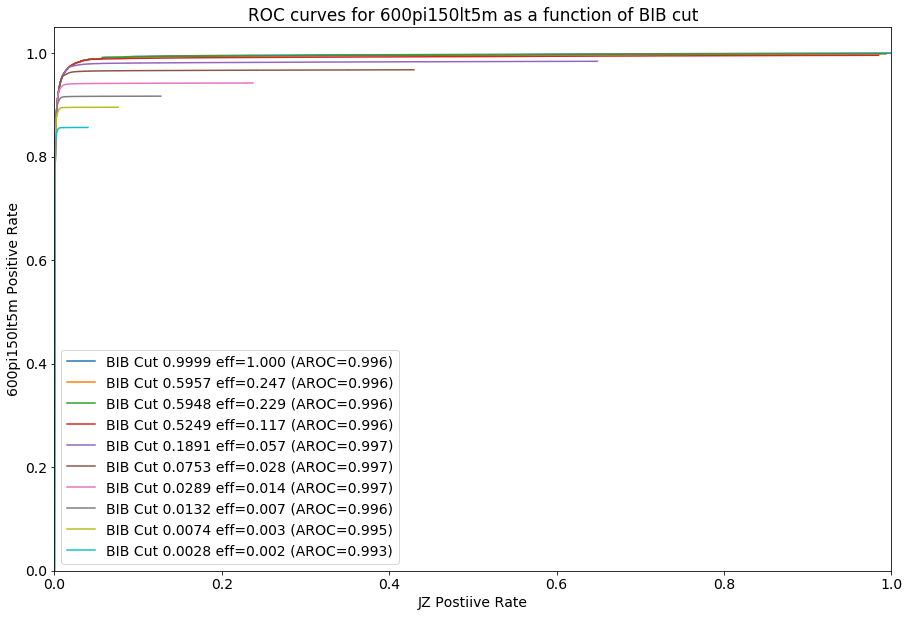

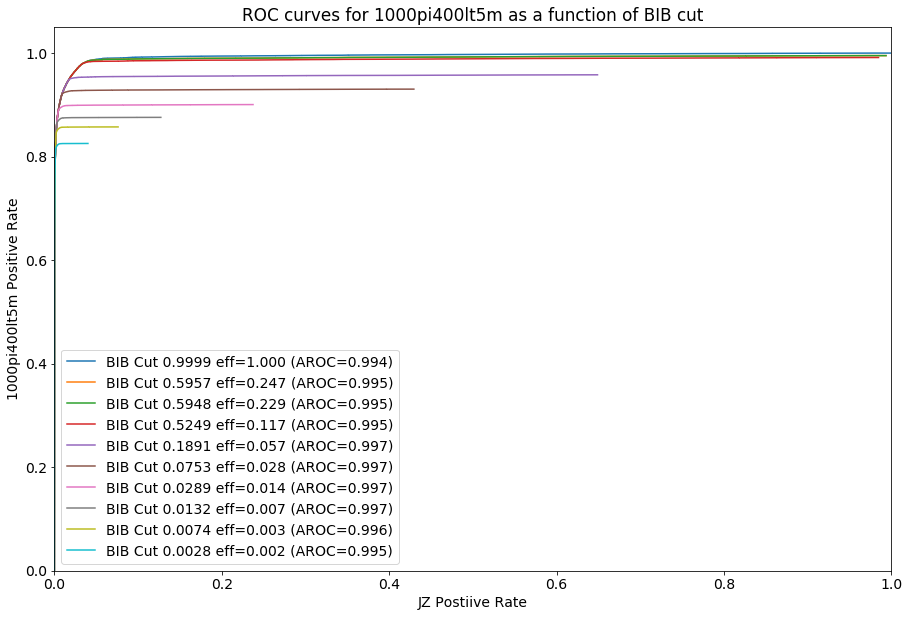

In [122]:
for sname in p_samples.keys():
    plot_roc_family_sample(p_samples[sname], sname)
    plt.show()